In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import gc
import logging
import datetime
import warnings
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error,roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold,train_test_split
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVR
import matplotlib.patches as patch
from scipy.stats import norm, skew
import xgboost as xgb
from catboost import CatBoostClassifier,Pool
%precision 4 
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import tree
import graphviz
from pdpbox import pdp,get_dataset,info_plots
import shap

'%.4f'

In [106]:
train=pd.read_csv(os.path.join(os.getcwd(),'data/santander_transaction/train copy.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/santander_transaction/test copy.csv'))
sample=pd.read_csv(os.path.join(os.getcwd(),'data/santander_transaction/sample_submission.csv'))
combined=[train,test]

In [3]:
## no missing values for both train & test
def missing_values(df):
    missing=df.isnull().sum().sort_values(ascending=False)
    percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_df=pd.concat([missing,percent],axis=1,keys=['missing','percent']).head(5)
    return missing_df
missing_values(train)

,missing,percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0


## EDA

In [4]:
def plot_feature_scatter(df1, df2,features):
    i=0
    plt.figure()
    fig,ax=plt.subplots(4,4,figsize=(14,14))
    for feature in features:
        i+=1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature],df2[feature],marker='+')
        plt.xlabel(feature,fontsize=9)

<Figure size 432x288 with 0 Axes>

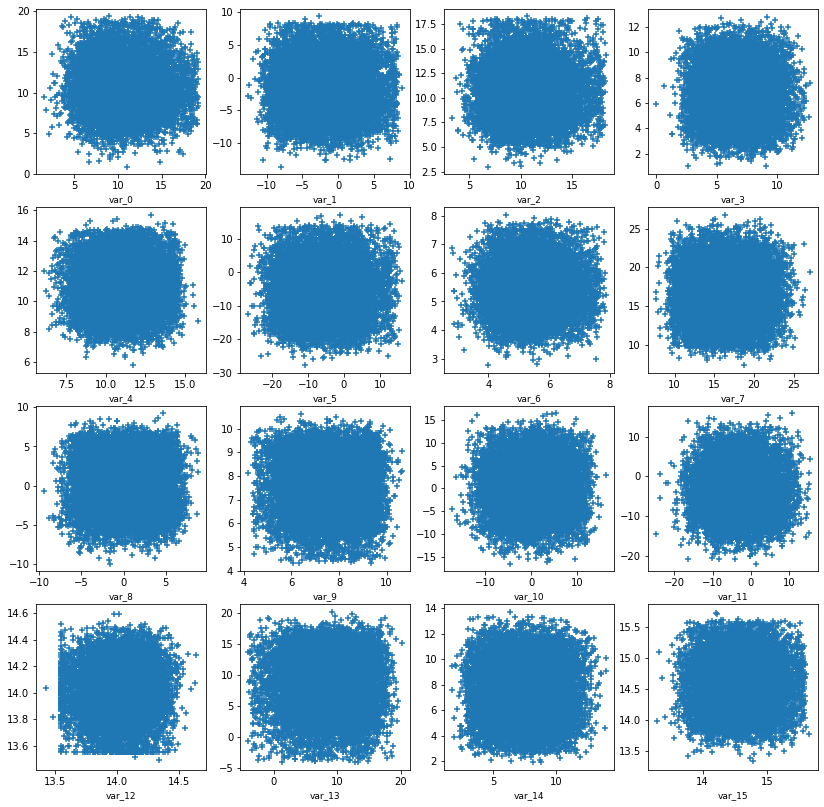

In [58]:
features=['var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11',
       'var_12', 'var_13', 'var_14', 'var_15']
plot_feature_scatter(train[::20],test[::20],features)

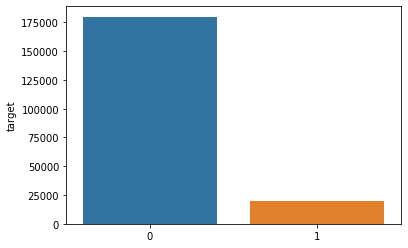

In [63]:
## data imbalance with target value
sns.barplot(train.target.value_counts().index,train.target.value_counts())

In [119]:
def plot_feature_distribution(df1,df2,label1,label2,features):
    i=0
    plt.figure()
    fig,ax=plt.subplots(10,10,figsize=(18,22))
    
    for feature in features:
        i+=1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature],hist=False,label=label1)
        sns.distplot(df2[feature],hist=False,label=label2)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)

<Figure size 432x288 with 0 Axes>

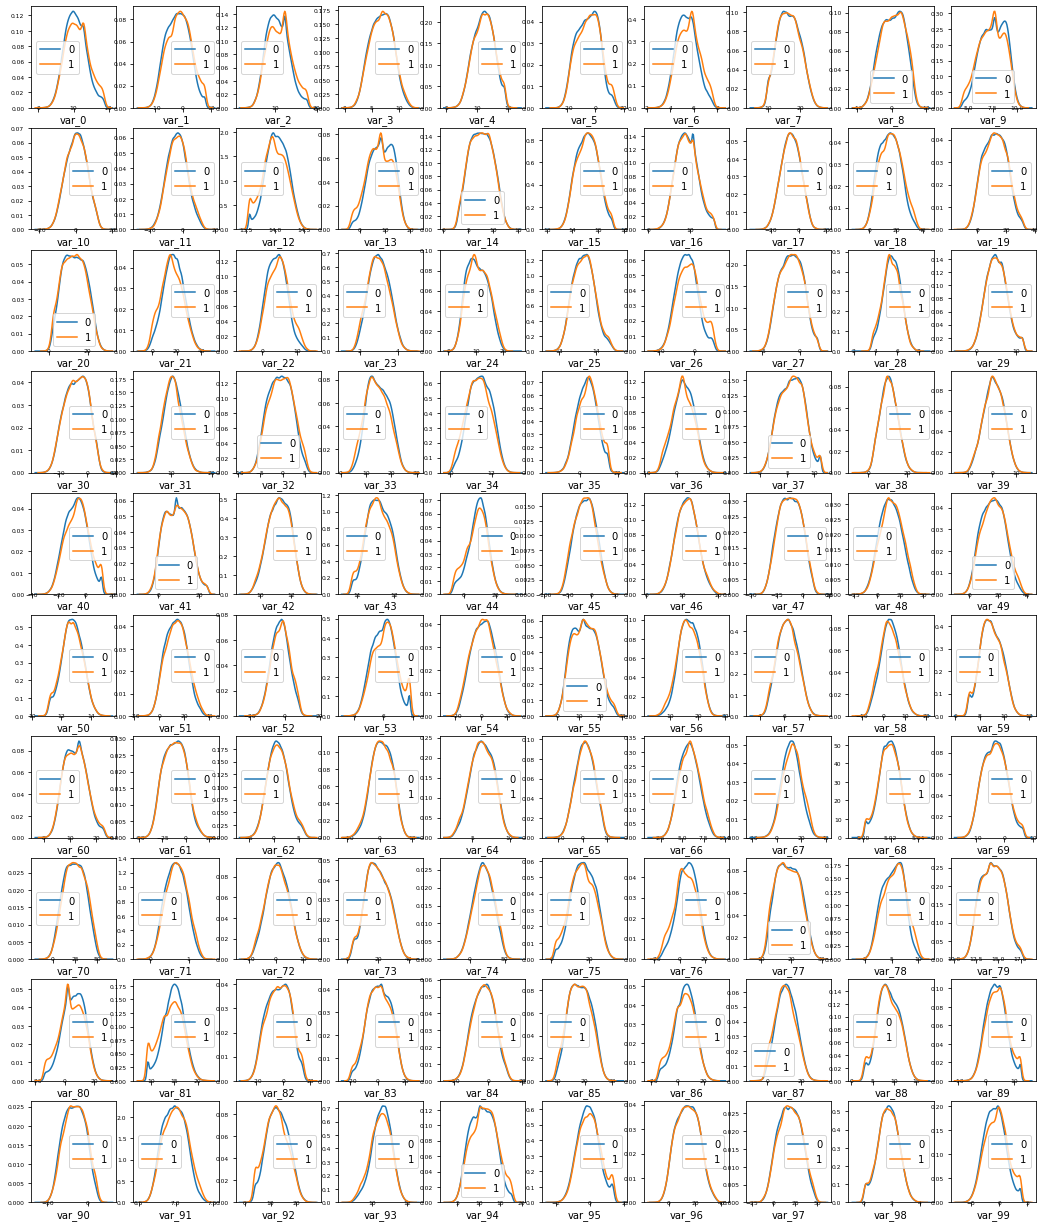

In [44]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

In [3]:
features=train.columns[2:202]

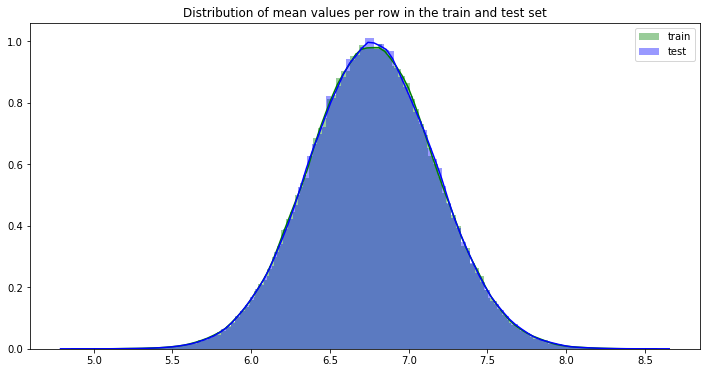

In [26]:
f,ax=plt.subplots(figsize=(12,6))
sns.distplot(train[features].mean(axis=1),color='green',kde=True,bins=120,label='train').set_title('Distribution of mean values per row in the train and test set')
sns.distplot(test[features].mean(axis=1),color='blue',kde=True,bins=120,label='test')
plt.legend()

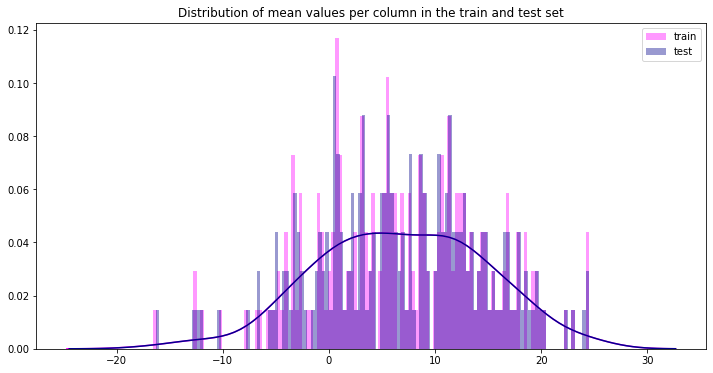

In [25]:
f,ax=plt.subplots(figsize=(12,6))
sns.distplot(train[features].mean(axis=0),kde=True,bins=120,label='train',color='magenta').set_title('Distribution of mean values per column in the train and test set')
sns.distplot(test[features].mean(axis=0),kde=True,bins=120,label='test',color='darkblue')
plt.legend()

In [47]:
corr=train[features].corr().abs().unstack().sort_values(ascending=False,kind='quicksort').reset_index()
corr=corr[corr['level_0']!=corr['level_1']]

In [61]:
## Duplicates in both train & test data
unique_max_train=[]
unique_max_test=[]
for feature in features:
    values=train[feature].value_counts()
    unique_max_train.append([feature,values.max(),values.idxmax()])
    values=test[feature].value_counts()
    unique_max_test.append([feature,values.max(),values.idxmax()])

In [98]:
np.transpose(pd.DataFrame(unique_max_test,columns=['Feature','Max duplicates','Value']).sort_values(by=['Max duplicates'],ascending=False))

,68,126,108,12,91,103,148,161,25,71,...,70,120,176,61,187,102,74,136,45,54
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,...,var_70,var_120,var_176,var_61,var_187,var_102,var_74,var_136,var_45,var_54
Max duplicates,1104,307,302,188,86,78,74,69,60,60,...,14,14,14,14,14,14,13,13,13,13
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,...,26.1051,21.9735,-2.0551,-11.0639,0.1931,18.272,16.5129,18.4871,-15.5899,2.5837


## Feature Engineering

In [20]:
for dataset in combined:
    dataset['sum']=dataset[features].sum(axis=1)
    dataset['min']=dataset[features].min(axis=1)
    dataset['max']=dataset[features].max(axis=1)
    dataset['mean']=dataset[features].mean(axis=1)
    dataset['std']=dataset[features].std(axis=1)
    dataset['skew']=dataset[features].skew(axis=1)
    dataset['kurt']=dataset[features].kurtosis(axis=1)
    dataset['median']=dataset[features].median(axis=1)

In [6]:
engineered_features=train.columns[202:]
def plot_new_feature_distribution(df1,df2,label1,label2,features):
    i=0
    plt.figure()
    f,ax=plt.subplots(2,4,figsize=(8,8))
    sns.set_style('whitegrid')
    for feature in features:
        i+=1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature],label=label1)
        sns.kdeplot(df2[feature],label=label2)
        locs,labels=plt.xticks()
        plt.tick_params(axis='x',which='major',labelsize=8)
        plt.tick_params(axis='y',which='major',labelsize=8)

<Figure size 432x288 with 0 Axes>

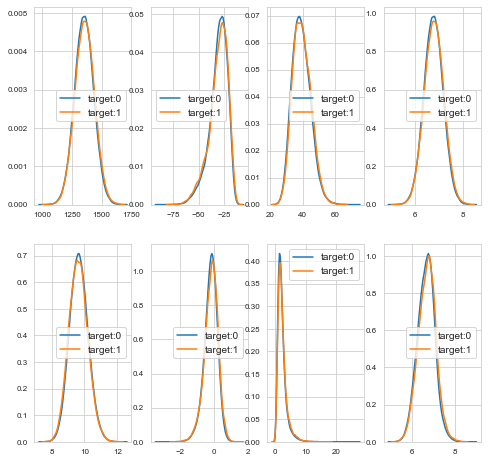

In [126]:
plot_new_feature_distribution(train[train.target==0],train[train.target==1],'target:0','target:1',engineered_features)

<Figure size 432x288 with 0 Axes>

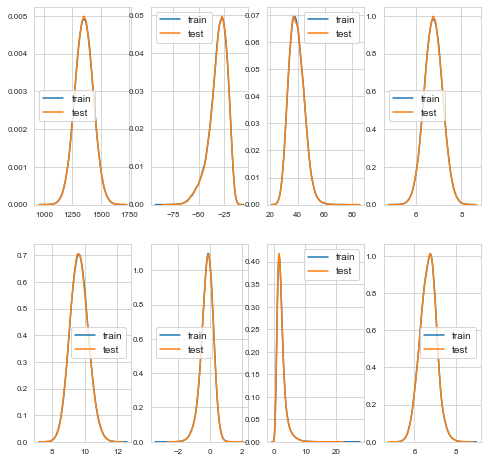

In [127]:
plot_new_feature_distribution(train,test,'train','test',engineered_features)

In [13]:
features=[c for c in train.columns if c not in ['ID_code','target']]

In [5]:
for dataset in combined:
    for feature in features:
        dataset['r2_'+feature]=np.round(dataset[feature],2)
        dataset['r1_'+feature]=np.round(dataset[feature],1)

In [6]:
train_copy=train.copy()
train_copy.drop(['ID_code','target'],axis=1,inplace=True)
target=train.target

In [22]:
params={
    'bagging_freq':5,
    'bagging_fraction':0.4,
    'boost_from_average':'false',
    'boost':'gbdt',
    'feature_fraction':0.05,
    'learning_rate':0.01,
    'max_depth':-1,
    'metric':'auc',
    'min_data_in_leaf':80,
    'min_sum_hessian_in_leaf':10.0,
    'num_leaves':13,
    'num_threads':8,
    'tree_learner':'serial',
    'objective':'binary',
    'verbosity':1  }

In [23]:
folds=StratifiedKFold(n_splits=10,shuffle=False,random_state=44000)
oof=np.zeros(train.shape[0])
predictions=np.zeros(test.shape[0])
feature_importances=[]

In [24]:
features=train.columns[2:]
for fold_,(trn_idx,val_idx) in enumerate(folds.split(train.values,target.values)):
    print('Fold {}'.format(fold_))
    X_train,X_val=train.iloc[trn_idx][features],train.iloc[val_idx][features]
    y_train,y_val=target.iloc[trn_idx],target.iloc[val_idx]
    trn_data = lgb.Dataset(X_train,label=y_train)
    val_data=lgb.Dataset(X_test,label=y_test)
    
    num_round =1000000
    clf=lgb.train(params,trn_data,num_round,valid_sets=[trn_data,val_data],verbose_eval=1000,early_stopping_rounds=3000)
    oof[val_idx]=clf.predict(train.iloc[val_idx][features],num_iteration=clf.best_iteration)
    
    fold_importance_df=pd.DataFrame()
    fold_importance_df['Feature']=features
    fold_importance_df['importance']=clf.feature_importance()
    fold_importance_df['fold']=fold_+1
    feature_importances=pd.concat([feature_importances,fold_importance_df],axis=0)
    predictions+=clf.predict(test[features],num_iteration=clf.best_iteration)/folds.n_splits
    print('CV score:{}'.format(roc_auc_score(target,oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.884728	valid_1's auc: 0.863536
[2000]	training's auc: 0.909434	valid_1's auc: 0.883532
[3000]	training's auc: 0.921014	valid_1's auc: 0.891689
[4000]	training's auc: 0.928325	valid_1's auc: 0.895453
[5000]	training's auc: 0.93396	valid_1's auc: 0.897526
[6000]	training's auc: 0.938877	valid_1's auc: 0.898503
[7000]	training's auc: 0.943435	valid_1's auc: 0.899148
[8000]	training's auc: 0.947698	valid_1's auc: 0.899409
[9000]	training's auc: 0.951759	valid_1's auc: 0.899567
[10000]	training's auc: 0.955626	valid_1's auc: 0.899515
[11000]	training's auc: 0.959272	valid_1's auc: 0.899445
[12000]	training's auc: 0.962723	valid_1's auc: 0.89902
Early stopping, best iteration is:
[9706]	training's auc: 0.954503	valid_1's auc: 0.899678
CV score:0.5040001088085906
Fold 1
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.884939	valid_1's auc: 0.866779
[2000]	train

In [44]:
masks=feature_importances.groupby(['Feature'])[['importance']].mean().sort_values(by='importance',ascending=False).head(150).index
best_features=feature_importances[feature_importances.Feature.isin(masks)]
best_features=best_features.sort_values(by=['importance'],ascending=False)

Text(0.5, 1.0, 'Feature Importance')

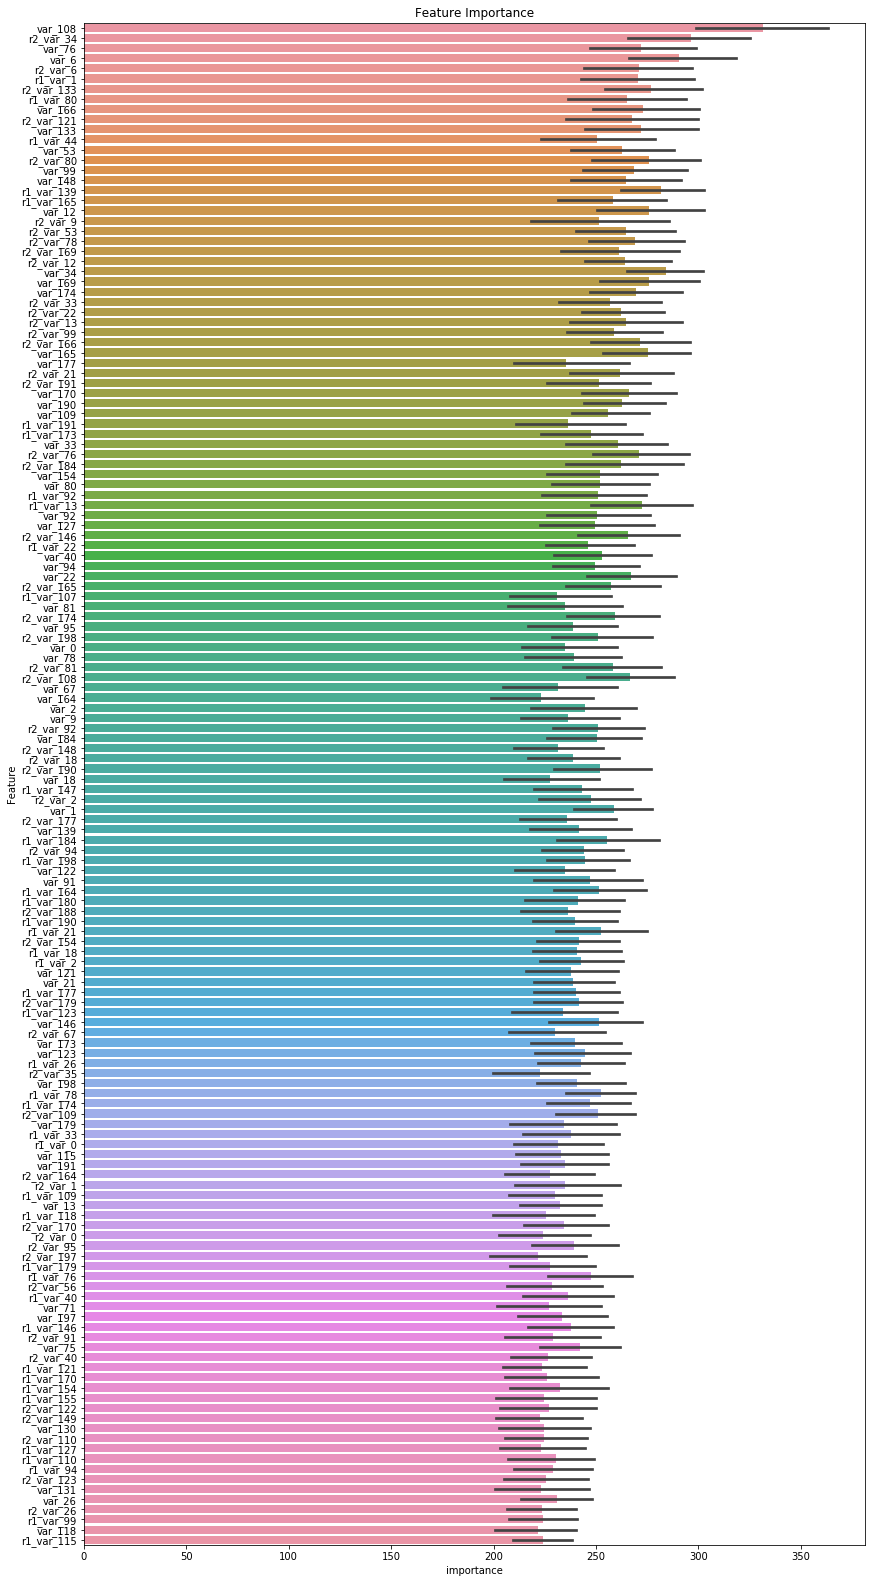

In [54]:
f,ax=plt.subplots(figsize=(14,28))
sns.barplot(best_features.importance,best_features.Feature).set_title('Feature Importance')

In [70]:
submission=pd.DataFrame({'ID':test.ID_code,'Prediction':np.round(predictions,0)})

In [74]:
submission.head(5)

,ID,Prediction
0,test_0,0.0
1,test_1,0.0
2,test_2,0.0
3,test_3,0.0
4,test_4,0.0


In [6]:
folds=StratifiedKFold(n_splits=5,shuffle=False,random_state=10)

In [7]:
def reduce_mem_usage(df):
    start_mem_usg=df.memory_usage().sum()/1024**2
    print('Memory usage of df is :{} MB'.format(start_mem_usg))
    NAlist=[]
    for col in df.columns:
        if df[col].dtype !=object:
            print('*'*50)
            print('Column:{}'.format(col))
            print('dtype before:{}'.format(df[col].dtype))
            
            IsInt=False
            mx=df[col].max()
            mn=df[col].min()
            
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)
            
            asint=df[col].fillna(0).astype(np.int64)
            result=(df[col]-asint)
            result=result.sum()
            if result >-0.01 and result<0.01:
                IsInt = True
                
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [8]:
train,NAlist=reduce_mem_usage(train)
test,NAlist=reduce_mem_usage(test)

Memory usage of df is :308.2276153564453 MB
**************************************************
Column:target
dtype before:int64
dtype after:  uint8
******************************
**************************************************
Column:var_0
dtype before:float64
dtype after:  float32
******************************
**************************************************
Column:var_1
dtype before:float64
dtype after:  float32
******************************
**************************************************
Column:var_2
dtype before:float64
dtype after:  float32
******************************
**************************************************
Column:var_3
dtype before:float64
dtype after:  float32
******************************
**************************************************
Column:var_4
dtype before:float64
dtype after:  float32
******************************
**************************************************
Column:var_5
dtype before:float64
dtype after:  float32
************************

Text(0.5, 1.0, 'Target Pie Chart')

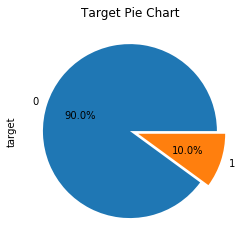

In [26]:
train.target.value_counts().plot(kind='pie',autopct='%1.1f%%',explode=[0,0.1])
plt.title('Target Pie Chart')

In [47]:
def plot_feature(df1,label1,features):
    i=0
    plt.figure()
    f,ax=plt.subplots(ncols=4,nrows=4,figsize=(12,12))
    for feature in features:
        i+=1
        plt.subplot(4,4,i)
        sns.violinplot(df1.target,df1[feature])
        locs,labels=plt.xticks()

<Figure size 432x288 with 0 Axes>

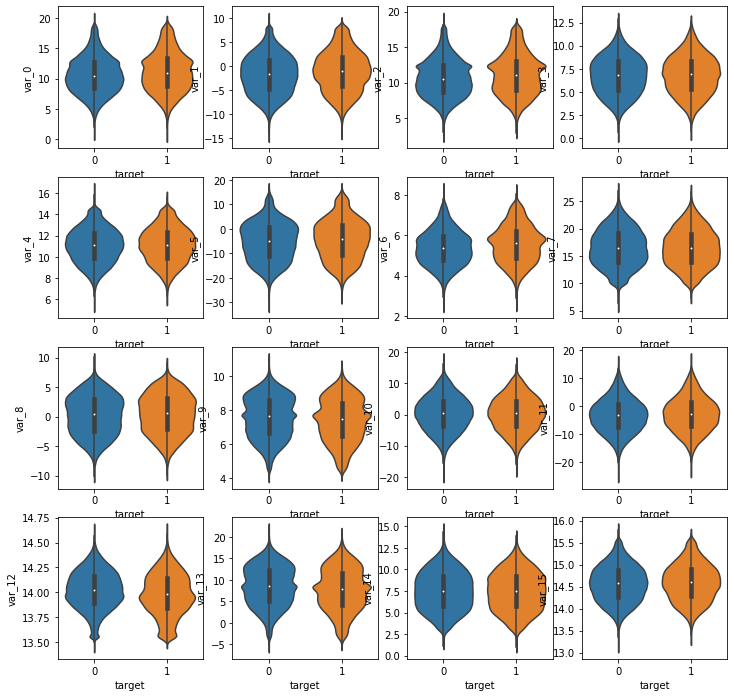

In [48]:
f=train.columns[2:18]
plot_feature(train,'train',f)

In [53]:
def check_missing(df):
    flag=df.isnull().sum().any()
    if flag==True:
        total=df.isnull().sum().sort_values(ascending=False)
        percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing=pd.concat([total,percent],axis=1,keys=['total','percent'])
        
        data_type=[]
        for col in columns:
            dtype=str(df[col].dtype)
            data_type.append(dtype)
        missing['Type']=data_type
        return (np.transpose(missing))
    else:
        return(False)       

In [95]:
X=train.drop(['ID_code','target'],axis=1)
y=train.target
X_test=test.drop(['ID_code'],axis=1)

### Eli5 Feature Importance

In [116]:
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=1)
rfc=RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [118]:
## Most important feature is : 'var_110'
perm=PermutationImportance(rfc,random_state=1).fit(X_val,y_val)
eli5.show_weights(perm,feature_names=X_val.columns.tolist(),top=100)

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


### Partial Dependence Plots

In [135]:
dtree=DecisionTreeClassifier(random_state=0,max_depth=5,min_samples_split=5).fit(X_train,y_train)
features=train.columns[2:]

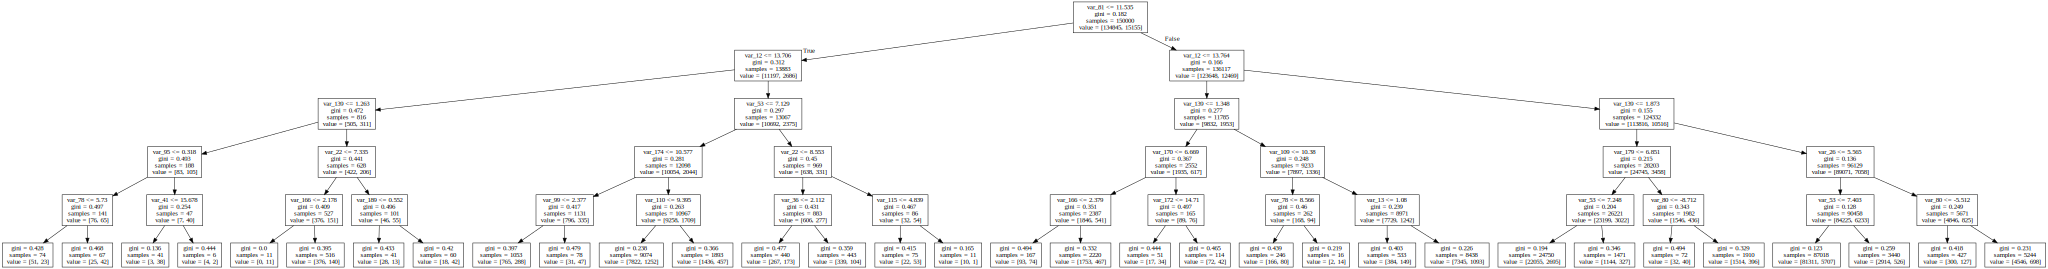

In [138]:
## var_81 major split root node 
tree_graph=tree.export_graphviz(dtree,out_file=None,feature_names=features)
graphviz.Source(tree_graph)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x17f901290>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13d454a10>})

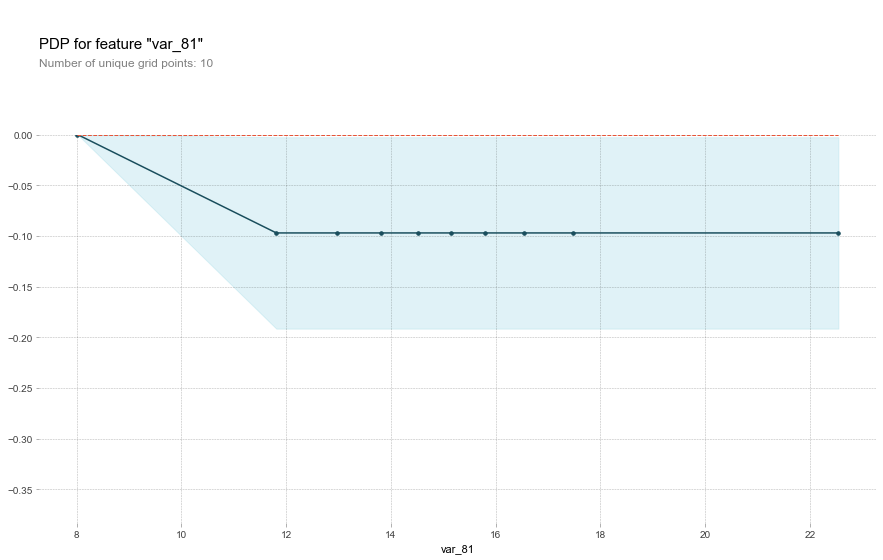

In [142]:
pdp_goals=pdp.pdp_isolate(model=dtree,dataset=X_val,model_features=features,feature='var_81')
pdp.pdp_plot(pdp_goals,'var_81')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13d14b4d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x14758c0d0>})

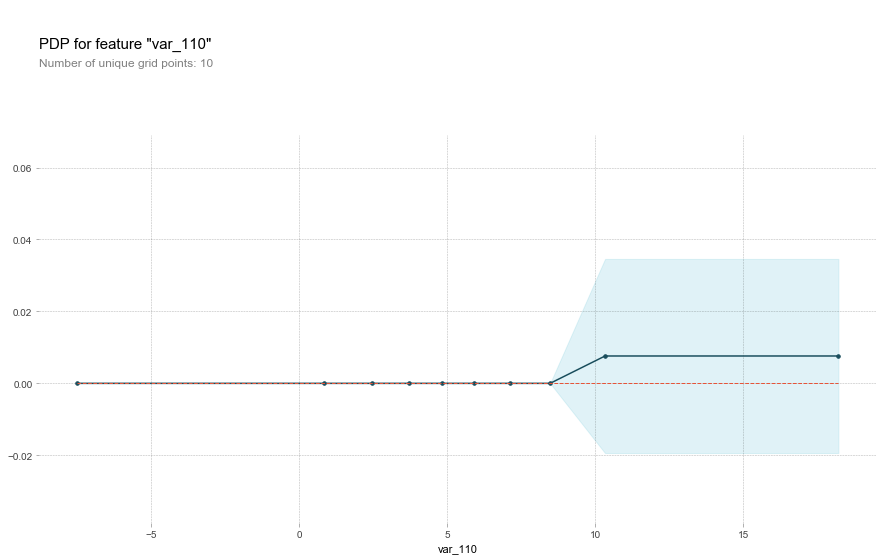

In [144]:
pdp_goals=pdp.pdp_isolate(model=dtree,dataset=X_val,model_features=features,feature='var_110')
pdp.pdp_plot(pdp_goals,'var_110')

In [166]:
pred_rfc=rfc.predict(X_test)
pred_dtree=dtree.predict(X_test)

In [170]:
train_pool=Pool(X_train,y_train)
cat=CatBoostClassifier(iterations=3000,learning_rate=0.03,objective='Logloss',eval_metric='AUC')
cat.fit(X_train,y_train,silent=True)
pred_cat=cat.predict(X_test)